In [1]:
!pip install facenet-pytorch==2.5.2 --quiet
!pip install scikit-learn matplotlib tqdm seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.4 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependenc

In [2]:
import os, sys, json, math, random, shutil
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 160
EPSILON = 16.0/255.0
PGD_STEPS = 60
PGD_ALPHA = 1.0/255.0
PGD_RESTARTS = 3
ADAM_ITERS = 200
ADAM_LR = 0.05
SAVE_DIR = Path("adv_results")
SAVE_DIR.mkdir(exist_ok=True)


In [3]:
cosine = nn.CosineSimilarity(dim=1, eps=1e-8)

def to_pil(tensor: torch.Tensor) -> Image.Image:
    if tensor.ndim == 4:
        tensor = tensor[0]
    arr = tensor.detach().cpu().permute(1,2,0).numpy()
    arr = (arr * 255.0).clip(0,255).astype('uint8')
    return Image.fromarray(arr)

def tensor_to_bgr_image(tensor: torch.Tensor) -> np.ndarray:
    pil = to_pil(tensor)
    arr = np.array(pil)[:,:,::-1]  # RGB->BGR
    return arr

def save_diff_heatmap(orig_tensor: torch.Tensor, adv_tensor: torch.Tensor, out_path: str):
    o = to_pil(orig_tensor).convert('L')
    a = to_pil(adv_tensor).convert('L')
    diff = np.abs(np.array(a).astype(np.int16) - np.array(o).astype(np.int16)).astype(np.uint8)
    diff = cv2.applyColorMap(diff, cv2.COLORMAP_JET)
    cv2.imwrite(out_path, diff)

def normalize_for_facenet(x: torch.Tensor) -> torch.Tensor:
    return (x - 0.5) * 2.0

def crop_face_tensor(mtcnn, pil_image: Image.Image, device=DEVICE):
    face = mtcnn(pil_image)
    if face is None:
        return None
    if face.ndimension() == 3:
        face = face.unsqueeze(0)
    return face.to(device)

@torch.no_grad()
def extract_embedding(resnet, face_tensor: torch.Tensor):
    x = face_tensor.to(device=DEVICE).float()
    emb = resnet(x)
    return emb  # (B, D)


In [4]:
mtcnn = MTCNN(image_size=IMG_SIZE, margin=0, device=DEVICE)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [7]:
EVAL_ROOT = Path("/kaggle/input/face-recognition-dataset/Original Images/Original Images") 
def load_image_paths(root: Path):
    samples = []
    for person_dir in sorted(root.iterdir()):
        if not person_dir.is_dir(): continue
        imgs = list(person_dir.glob("*.jpg"))
        if len(imgs) < 1: continue
        for p in imgs:
            samples.append((person_dir.name, str(p)))
    return samples

samples = load_image_paths(EVAL_ROOT)
len(samples)


2562

# compute embeddings for all images

In [8]:
embeddings = {}  # path -> embedding (1,D) cpu numpy
failed = []
for person, path in tqdm(samples):
    try:
        img = Image.open(path).convert("RGB")
        face = crop_face_tensor(mtcnn, img, device=DEVICE)
        if face is None:
            failed.append(path); continue
        emb = extract_embedding(resnet, face)  # tensor on device
        embeddings[path] = emb.cpu().numpy()[0]
    except Exception as e:
        failed.append(path)
print("computed:", len(embeddings), "failed:", len(failed))
# Save
np.save(SAVE_DIR / "baseline_embeddings.npy", embeddings)


100%|██████████| 2562/2562 [07:58<00:00,  5.35it/s]

computed: 2562 failed: 0


In [9]:
from itertools import combinations, product
# group paths by person
by_person = {}
for person, path in samples:
    by_person.setdefault(person, []).append(path)

# create genuine pairs (per person) and random impostor pairs
genuine_pairs = []
for p, imgs in by_person.items():
    for a,b in combinations(imgs, 2):
        if a in embeddings and b in embeddings:
            genuine_pairs.append((a,b))
# impostor: sample N pairs
impostor_pairs = []
persons = list(by_person.keys())
random.seed(42)
while len(impostor_pairs) < min(2000, len(genuine_pairs)*2):
    p1, p2 = random.sample(persons, 2)
    a = random.choice(by_person[p1]); b = random.choice(by_person[p2])
    if a in embeddings and b in embeddings:
        impostor_pairs.append((a,b))

def pair_scores(pairs, emb_map):
    scores = []
    for a,b in pairs:
        sa = emb_map[a]; sb = emb_map[b]
        sim = float(np.dot(sa, sb) / (np.linalg.norm(sa)*np.linalg.norm(sb) + 1e-10))
        scores.append(sim)
    return np.array(scores)

g_scores = pair_scores(genuine_pairs, embeddings)
i_scores = pair_scores(impostor_pairs, embeddings)

print("genuine mean", g_scores.mean(), "impostor mean", i_scores.mean())


genuine mean 0.7231394888624102 impostor mean 0.03041648769671145


AUC: 0.9937, EER≈0.0134


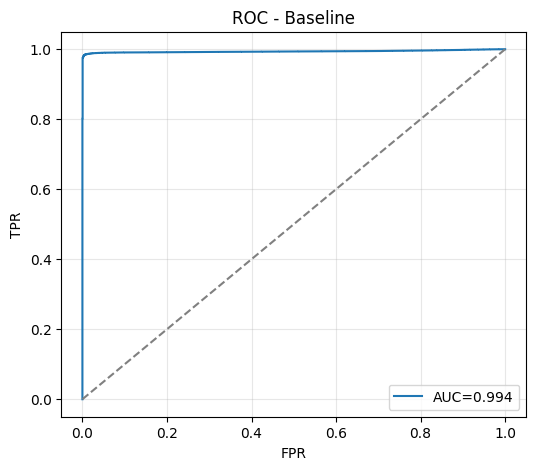

In [10]:
y_true = np.concatenate([np.ones_like(g_scores), np.zeros_like(i_scores)])
y_score = np.concatenate([g_scores, i_scores])
fpr, tpr, thr = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# EER: fpr ~= 1 - tpr
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = (fnr[eer_idx] + fpr[eer_idx]) / 2.0

print(f"AUC: {roc_auc:.4f}, EER≈{eer:.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Baseline")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [31]:
def fgsm_targeted_once(resnet, orig_tensor, embB, epsilon=EPSILON, device=DEVICE):
    resnet.eval()
    adv = orig_tensor.clone().detach().to(device)
    adv.requires_grad_(True)
    #x_in = normalize_for_facenet(adv)
    x_in = adv

    embA = resnet(x_in)
    loss = (1.0 - cosine(embA, embB)).mean()
    resnet.zero_grad(set_to_none=True)
    if adv.grad is not None: adv.grad.zero_()
    loss.backward()
    grad_sign = adv.grad.data.sign()
    adv_pert = adv - epsilon * grad_sign
    adv_pert = torch.clamp(adv_pert, 0.0, 1.0).detach()
    return adv_pert


In [40]:
selected_pairs = []  # list of tuples (src_path, target_path)
# Example: choose some impostor pairs where sim_before is low (so attack is meaningful)
for name_a, path_a, name_b, path_b in impostor_pairs[:200]:
    selected_pairs.append((path_a, path_b))  # chỉ lấy path để attack
os.makedirs(SAVE_DIR / "adv_images", exist_ok=True)

adv_results = []  # store dicts
for src, tgt in tqdm(selected_pairs):
    face_src = crop_face_tensor(mtcnn, Image.open(src).convert("RGB"), device=DEVICE)
    face_tgt = crop_face_tensor(mtcnn, Image.open(tgt).convert("RGB"), device=DEVICE)
    if face_src is None or face_tgt is None: continue
    with torch.no_grad():
        embB = extract_embedding(resnet, face_tgt)  # (1,D)
        embA_orig = extract_embedding(resnet, face_src)
        sim_before = float(cosine(embA_orig, embB).item())
    # FGSM single-step
    adv = fgsm_targeted_once(resnet, face_src, embB, epsilon=EPSILON)
    with torch.no_grad():
        embA_adv = extract_embedding(resnet, adv)
        sim_after = float(cosine(embA_adv, embB).item())
    # save visuals
    idx = len(adv_results)
    cv2.imwrite(str(SAVE_DIR / "adv_images" / f"adv_{idx}_src.png"), tensor_to_bgr_image(face_src.cpu()))
    cv2.imwrite(str(SAVE_DIR / "adv_images" / f"adv_{idx}_adv.png"), tensor_to_bgr_image(adv.cpu()))
    try:
        save_diff_heatmap(face_src.cpu(), adv.cpu(), str(SAVE_DIR / "adv_images" / f"adv_{idx}_heatmap.png"))
    except Exception:
        pass
    adv_results.append({"src": src, "tgt": tgt, "sim_before": sim_before, "sim_after": sim_after,
                        "adv_path": f"adv_images/adv_{idx}_adv.png"})
print("created", len(adv_results), "adversarial examples")


100%|██████████| 200/200 [01:23<00:00,  2.38it/s]

created 200 adversarial examples


Attacks succeeded (sim >= 0.6): 30/200 = 15.00%
AUC baseline: 0.9937  after adding adv: 0.9872


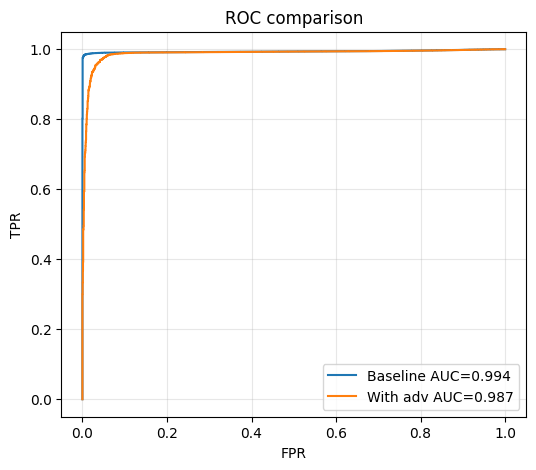

In [41]:
threshold = 0.6 # choose sensibly, or compute from baseline ROC (e.g., thr at EER)
# Count how many adv cause sim_after >= threshold
succ = sum(1 for r in adv_results if r["sim_after"] >= threshold)
print(f"Attacks succeeded (sim >= {threshold}): {succ}/{len(adv_results)} = {100*succ/len(adv_results):.2f}%")

# Optional: append adv pairs to impostor list and recompute ROC
adv_scores = np.array([r["sim_after"] for r in adv_results])
y_true_aug = np.concatenate([np.ones_like(g_scores), np.zeros_like(i_scores), np.zeros_like(adv_scores)])
y_score_aug = np.concatenate([g_scores, i_scores, adv_scores])
fpr_a, tpr_a, _ = roc_curve(y_true_aug, y_score_aug)
auc_a = auc(fpr_a, tpr_a)
print(f"AUC baseline: {roc_auc:.4f}  after adding adv: {auc_a:.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Baseline AUC={roc_auc:.3f}")
plt.plot(fpr_a, tpr_a, label=f"With adv AUC={auc_a:.3f}")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC comparison"); plt.grid(alpha=0.3)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


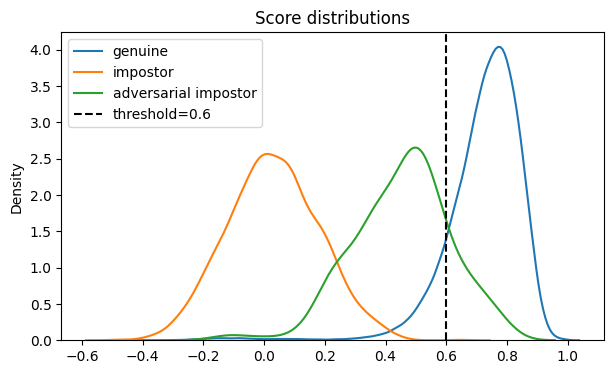

/kaggle/input/face-recognition-dataset/Original Images/Original Images/Akshay Kumar/Akshay Kumar_8.jpg -> /kaggle/input/face-recognition-dataset/Original Images/Original Images/Robert Downey Jr/Robert Downey Jr_27.jpg before=0.102 after=0.618


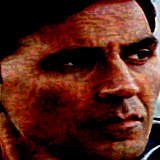

/kaggle/input/face-recognition-dataset/Original Images/Original Images/Dwayne Johnson/Dwayne Johnson_15.jpg -> /kaggle/input/face-recognition-dataset/Original Images/Original Images/Brad Pitt/Brad Pitt_112.jpg before=0.157 after=0.770


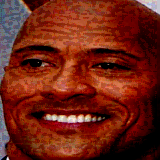

/kaggle/input/face-recognition-dataset/Original Images/Original Images/Hrithik Roshan/Hrithik Roshan_14.jpg -> /kaggle/input/face-recognition-dataset/Original Images/Original Images/Zac Efron/Zac Efron_46.jpg before=0.170 after=0.784


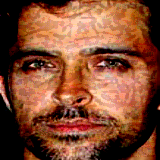

/kaggle/input/face-recognition-dataset/Original Images/Original Images/Hrithik Roshan/Hrithik Roshan_56.jpg -> /kaggle/input/face-recognition-dataset/Original Images/Original Images/Hugh Jackman/Hugh Jackman_69.jpg before=0.207 after=0.732


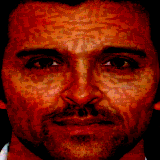

/kaggle/input/face-recognition-dataset/Original Images/Original Images/Vijay Deverakonda/Vijay Deverakonda_85.jpg -> /kaggle/input/face-recognition-dataset/Original Images/Original Images/Zac Efron/Zac Efron_88.jpg before=0.059 after=0.635


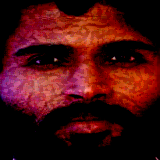

In [42]:
plt.figure(figsize=(7,4))
sns.kdeplot(g_scores, label="genuine")
sns.kdeplot(i_scores, label="impostor")
sns.kdeplot(adv_scores, label="adversarial impostor")
plt.axvline(threshold, color='k', linestyle='--', label=f"threshold={threshold}")
plt.legend(); plt.title("Score distributions")
plt.show()

# show top successful adv examples
successful = [r for r in adv_results if r["sim_after"] >= threshold]
for r in successful[:5]:
    print(r["src"], "->", r["tgt"], f"before={r['sim_before']:.3f}", f"after={r['sim_after']:.3f}")
    display(Image.open(SAVE_DIR / r["adv_path"]))


# PGD Evaluation

In [43]:
import torch
import numpy as np
import cv2

def pgd_with_restarts(resnet,
                      orig_adv,   # tensor (1,C,H,W) in [0,1]
                      embB,       # tensor (1,D) target embedding (on device)
                      eps=16.0/255.0,
                      steps=60,
                      alpha=1.0/255.0,
                      restarts=3,
                      device=DEVICE,
                      use_momentum=True,
                      mu=1.0,
                      save_prefix: str = None):
    resnet.eval()
    orig = orig_adv.clone().detach().to(device)
    best_sim = -1.0
    best_adv = orig.clone().detach()
    best_trace = None

    for r in range(restarts):
        # random start inside L_inf ball
        rand = torch.empty_like(orig).uniform_(-eps, eps).to(device)
        adv = torch.clamp(orig + rand, 0.0, 1.0).detach()
        if use_momentum:
            g_m = torch.zeros_like(adv)

        sims = []
        # we will do in-place updates on adv.data to keep it a leaf tensor
        adv = adv.clone().detach()
        adv.requires_grad_(True)
        for it in range(steps):
            # forward
            x_in = adv           # to [-1,1]
            embA_adv = resnet(x_in)                    # (1,D)
            loss = (1.0 - cosine(embA_adv, embB)).mean()

            # backward
            if adv.grad is not None:
                adv.grad.zero_()
            resnet.zero_grad(set_to_none=True)
            loss.backward()
            grad = adv.grad.detach()

            if use_momentum:
                # stabilize momentum using mean abs normalizer
                denom = (grad.abs().mean().clamp(min=1e-12))
                g_m = mu * g_m + grad / denom
                step = alpha * g_m.sign()
            else:
                step = alpha * grad.sign()

            # gradient descent step (we minimize loss -> increase cosine)
            adv.data = (adv.data - step).clamp(0.0, 1.0)

            # project to L_inf ball around orig
            adv.data = torch.max(torch.min(adv.data, orig + eps), orig - eps).clamp(0.0,1.0)

            # record sim
            with torch.no_grad():
                emb_tmp = resnet(normalize_for_facenet(adv))
                sim_tmp = float(cosine(emb_tmp, embB).item())
            sims.append(sim_tmp)

            # prepare for next iter (ensure adv requires_grad)
            if it != steps-1:
                adv.grad.zero_()
        # end iterations

        final_sim = sims[-1] if len(sims)>0 else -1.0
        if final_sim > best_sim:
            best_sim = final_sim
            best_adv = adv.clone().detach()
            best_trace = sims

    #-save visuals if requested
    if save_prefix and best_adv is not None:
        try:
            cv2.imwrite(f"{save_prefix}_pgd_best.png", tensor_to_bgr_image(best_adv.cpu()))
            save_diff_heatmap(orig.cpu(), best_adv.cpu(), f"{save_prefix}_pgd_heatmap.png")
        except Exception:
            pass

    stats = {
        "best_sim": best_sim,
        "sims_trace": best_trace,
        "epsilon": eps,
        "steps": steps,
        "alpha": alpha,
        "restarts": restarts,
        "use_momentum": use_momentum
    }
    return best_adv.cpu(), stats


PGD eval: 100%|██████████| 200/200 [17:07<00:00,  5.14s/it]

created 200 PGD adversarial examples
Attacks succeeded (sim >= 0.6): 199/200 = 99.50%
AUC baseline: 0.9937 | after adding adv: 0.9073


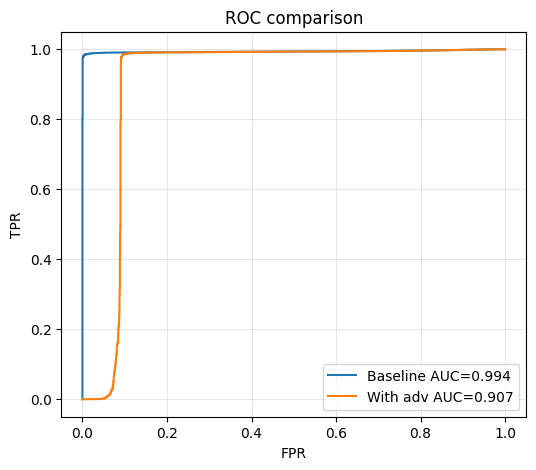

In [47]:
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
MOMENTUM_MU = 1.0 
try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
except Exception:
    pass

selected_pairs = [(path_a, path_b) for (name_a, path_a, name_b, path_b) in impostor_pairs[:200]]

SAVE_DIR = Path(SAVE_DIR) if 'SAVE_DIR' in globals() else Path("./results")
(SAVE_DIR / "adv_images").mkdir(parents=True, exist_ok=True)

adv_results = []  # list of dict
for idx, (src, tgt) in enumerate(tqdm(selected_pairs, total=len(selected_pairs), desc="PGD eval")):
    # crop faces
    try:
        face_src = crop_face_tensor(mtcnn, Image.open(src).convert("RGB"), device=DEVICE)   # (1,C,H,W) in [0,1]
        face_tgt = crop_face_tensor(mtcnn, Image.open(tgt).convert("RGB"), device=DEVICE)
    except Exception as e:
        print(f"[skip {idx}] open/crop error: {e}")
        continue

    if face_src is None or face_tgt is None:
        # no face found; skip
        continue

    # ensure batch dim
    if face_src.dim() == 3: face_src = face_src.unsqueeze(0)
    if face_tgt.dim() == 3: face_tgt = face_tgt.unsqueeze(0)

    # embeddings before attack
    with torch.no_grad():
        embB = extract_embedding(resnet, face_tgt)       # (1,D)
        embA0 = extract_embedding(resnet, face_src)      # (1,D)
        sim_before = float(F.cosine_similarity(embA0, embB).item())

    adv_tensor, stats = pgd_with_restarts(
        resnet,
        face_src,                # (1,C,H,W) in [0,1]
        embB.to(next(resnet.parameters()).device),
        eps=EPSILON,
        steps=PGD_STEPS,
        alpha=PGD_ALPHA,
        restarts=PGD_RESTARTS,
        device=next(resnet.parameters()).device,
        use_momentum=USE_MOMENTUM,
        mu=MOMENTUM_MU,
        save_prefix=str(SAVE_DIR / "adv_images" / f"pgd_{idx}")  # auto-save best & heatmap inside
    )

    with torch.no_grad():
        embA_adv = extract_embedding(resnet, adv_tensor.to(next(resnet.parameters()).device))
        sim_after = float(F.cosine_similarity(embA_adv, embB).item())

    try:
        cv2.imwrite(str(SAVE_DIR / "adv_images" / f"pgd_{idx}_src.png"), tensor_to_bgr_image(face_src.cpu()))
        cv2.imwrite(str(SAVE_DIR / "adv_images" / f"pgd_{idx}_adv.png"), tensor_to_bgr_image(adv_tensor.cpu()))
    except Exception:
        pass

    adv_results.append({
        "src": src, "tgt": tgt,
        "sim_before": sim_before, "sim_after": sim_after,
        "adv_path": f"adv_images/pgd_{idx}_adv.png",
        **(stats if isinstance(stats, dict) else {"stats": stats})
    })

print("created", len(adv_results), "PGD adversarial examples")

threshold = 0.6  
succ = sum(1 for r in adv_results if r["sim_after"] >= threshold)
rate = (100.0 * succ / max(1, len(adv_results)))
print(f"Attacks succeeded (sim >= {threshold}): {succ}/{len(adv_results)} = {rate:.2f}%")

if all(v in globals() for v in ["g_scores", "i_scores", "fpr", "tpr", "roc_auc"]):
    try:
        adv_scores = np.array([r["sim_after"] for r in adv_results], dtype=np.float32)
        y_true_aug  = np.concatenate([np.ones_like(g_scores), np.zeros_like(i_scores), np.zeros_like(adv_scores)])
        y_score_aug = np.concatenate([g_scores, i_scores, adv_scores])
        fpr_a, tpr_a, _ = roc_curve(y_true_aug, y_score_aug)
        auc_a = auc(fpr_a, tpr_a)
        print(f"AUC baseline: {roc_auc:.4f} | after adding adv: {auc_a:.4f}")

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"Baseline AUC={roc_auc:.3f}")
        plt.plot(fpr_a, tpr_a, label=f"With adv AUC={auc_a:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC comparison"); plt.grid(alpha=0.3); plt.legend()
        plt.show()
    except Exception as e:
        print("ROC augmentation skipped due to error:", e)
else:
    print("ROC augmentation skipped (baseline vars not found: need g_scores, i_scores, fpr, tpr, roc_auc).")


Attacks succeeded (sim >= 0.9): 148/200 = 74.00%
AUC baseline: 0.9937 | after adding adv: 0.9073


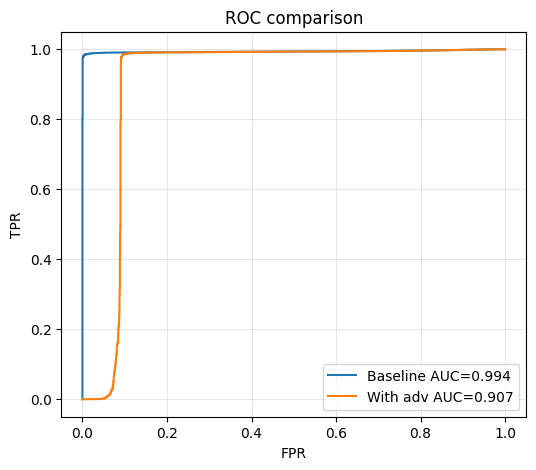

In [49]:
threshold = 0.9
succ = sum(1 for r in adv_results if r["sim_after"] >= threshold)
rate = (100.0 * succ / max(1, len(adv_results)))
print(f"Attacks succeeded (sim >= {threshold}): {succ}/{len(adv_results)} = {rate:.2f}%")

if all(v in globals() for v in ["g_scores", "i_scores", "fpr", "tpr", "roc_auc"]):
    try:
        adv_scores = np.array([r["sim_after"] for r in adv_results], dtype=np.float32)
        y_true_aug  = np.concatenate([np.ones_like(g_scores), np.zeros_like(i_scores), np.zeros_like(adv_scores)])
        y_score_aug = np.concatenate([g_scores, i_scores, adv_scores])
        fpr_a, tpr_a, _ = roc_curve(y_true_aug, y_score_aug)
        auc_a = auc(fpr_a, tpr_a)
        print(f"AUC baseline: {roc_auc:.4f} | after adding adv: {auc_a:.4f}")

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"Baseline AUC={roc_auc:.3f}")
        plt.plot(fpr_a, tpr_a, label=f"With adv AUC={auc_a:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC comparison"); plt.grid(alpha=0.3); plt.legend()
        plt.show()
    except Exception as e:
        print("ROC augmentation skipped due to error:", e)
else:
    print("ROC augmentation skipped (baseline vars not found: need g_scores, i_scores, fpr, tpr, roc_auc).")


# Adversarial Trainning

In [58]:
# ===== Adversarial Training (freeze FaceNet, train projection head) =====
import os, random
from pathlib import Path
from typing import List
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import cv2

# ---------------- CONFIG ----------------
DEVICE = next(resnet.parameters()).device          # FaceNet device
TRAIN_BATCH = 8
EPOCHS = 3
ITERS_PER_EPOCH = 25
LR = 1e-3

# loss weights
LAMBDA_PUSH = 1.0
MARGIN = 0.0        # nếu muốn đẩy xa hơn, thử 0.1~0.3

IMG_SIZE = 160
IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".webp")

# PGD hyperparams (giống bạn)
EPSILON      = 16.0/255.0
PGD_STEPS    = 30
PGD_ALPHA    = 1.0/255.0
PGD_RESTARTS = 1
USE_MOMENTUM = True
MOMENTUM_MU  = 1.0

# ---- helpers (fallback) ----
if 'normalize_for_facenet' not in globals():
    def normalize_for_facenet(x): return x * 2.0 - 1.0

def _is_img(path: str) -> bool:
    p = str(path).lower()
    return any(p.endswith(ext) for ext in IMG_EXTS)

def unique_existing_paths_from_impostors(impostor_pairs) -> List[str]:
    paths = []
    for item in impostor_pairs:
        if len(item) == 4:
            _, p1, _, p2 = item
            paths += [p1, p2]
        elif len(item) == 2:
            p1, p2 = item
            paths += [p1, p2]
    uniq, seen = [], set()
    for p in paths:
        p = str(p)
        if p not in seen and os.path.isfile(p) and _is_img(p):
            uniq.append(p); seen.add(p)
    return uniq

# ---------------- DATASET ----------------
class FaceCropDataset(Dataset):
    def __init__(self, paths: List[str], mtcnn, device):
        self.paths  = paths
        self.mtcnn  = mtcnn
        self.device = device

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        face = crop_face_tensor(self.mtcnn, img, device=self.device)  # (1,C,H,W) in [0,1] or None
        if face is None:
            # cố gắng thay thế để giữ batch size ổn định
            for _ in range(5):
                p2 = random.choice(self.paths)
                try:
                    img2 = Image.open(p2).convert("RGB")
                    face2 = crop_face_tensor(self.mtcnn, img2, device=self.device)
                    if face2 is not None:
                        face = face2
                        break
                except:
                    pass
        if face is None:
            face = torch.zeros(1,3,IMG_SIZE,IMG_SIZE, device=self.device)
        if face.dim()==3:
            face = face.unsqueeze(0)
        return {"path": p, "faces": face}  # faces: (1,C,H,W)

def collate_pad(batch):
    faces = torch.cat([b["faces"] for b in batch], dim=0)   # (B,C,H,W)
    paths = [b["path"] for b in batch]
    return {"faces": faces, "paths": paths}

# ---------------- DATALOADER ----------------
train_paths = unique_existing_paths_from_impostors(impostor_pairs)
print(f"[Dataset] using {len(train_paths)} valid image files.")

loader = DataLoader(
    FaceCropDataset(train_paths, mtcnn, device=DEVICE),
    batch_size=TRAIN_BATCH,
    shuffle=True,
    num_workers=0,          # tránh lỗi CUDA + fork
    pin_memory=False,
    collate_fn=collate_pad,
    drop_last=True          # luôn đủ B phần tử để BN/perm hoạt động
)

# ---------------- MODEL ----------------
class ProjHead(nn.Module):
    def __init__(self, in_dim=512, hid=512, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(inplace=True),
            nn.Linear(hid, out_dim),
            nn.LayerNorm(out_dim, elementwise_affine=True)
        )
    def forward(self, x):
        z = self.net(x)
        return F.normalize(z, dim=-1)   # dùng cosine dễ

head = ProjHead().to(DEVICE)
opt  = torch.optim.AdamW(head.parameters(), lr=LR)

# Freeze FaceNet, eval để không dính BatchNorm train-mode
for p in resnet.parameters(): p.requires_grad = False
resnet.eval()

# ---------------- TRAIN LOOP ----------------
print(f"Start adversarial training: {EPOCHS} epochs, {ITERS_PER_EPOCH} it/epoch")
for epoch in range(EPOCHS):
    head.train()
    it = 0
    pbar = tqdm(loader, total=ITERS_PER_EPOCH, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        if it >= ITERS_PER_EPOCH: break

        faces = batch["faces"].to(DEVICE)     # (B,C,H,W) in [0,1]
        B = faces.size(0)

        # 1) Clean embeddings (FaceNet cố định)
        with torch.no_grad():
            emb_clean = resnet(normalize_for_facenet(faces))   # (B,512)

        # project to z-space
        z_clean = head(emb_clean)                                # (B,512) normalized

        # 2) Tạo target hoán vị trong batch (khác người)
        perm    = torch.randperm(B, device=DEVICE)
        emb_tgt = emb_clean[perm]                                # (B,512)
        z_tgt   = head(emb_tgt).detach()                         # detach để không chảy grad vào nhánh target

        # 3) Sinh ảnh adversarial hướng về target-embedding (trên FaceNet, không qua head)
        adv_list = []
        for i in range(B):
            x_i = faces[i:i+1].detach()
            e_t = emb_tgt[i:i+1].detach()
            adv_i, _ = pgd_with_restarts(
                resnet,
                x_i, e_t,
                eps=EPSILON, steps=PGD_STEPS, alpha=PGD_ALPHA,
                restarts=PGD_RESTARTS, device=DEVICE,
                use_momentum=USE_MOMENTUM, mu=MOMENTUM_MU,
                save_prefix=None
            )
            adv_list.append(adv_i.to(DEVICE))
        x_adv = torch.cat(adv_list, dim=0)                        # (B,C,H,W)

        # 4) Embed lại adversarial -> project
        with torch.no_grad():
            emb_adv = resnet(normalize_for_facenet(x_adv))       # (B,512)
        z_adv = head(emb_adv)                                     # (B,512)

        # 5) Loss
        # Consistency: muốn z_adv ~ z_clean
        L_cons = (1.0 - F.cosine_similarity(z_adv, z_clean, dim=-1)).mean()

        # Push-away: tránh z_adv gần z_tgt (margin hinge)
        cos_t  = F.cosine_similarity(z_adv, z_tgt, dim=-1)        # (B,)
        L_push = F.relu(cos_t - MARGIN).mean()

        loss = L_cons + LAMBDA_PUSH * L_push

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        it += 1
        pbar.set_postfix(loss=float(loss.item()),
                         cons=float(L_cons.item()),
                         push=float(L_push.item()))

print("Adversarial training DONE.")


[Dataset] using 2035 valid image files.
Start adversarial training: 3 epochs, 25 it/epoch


Epoch 3/3: 100%|██████████| 25/25 [05:48<00:00, 13.93s/it, cons=0.00128, loss=1, push=0.999] 

Adversarial training DONE.
